In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

pd.options.display.max_columns = 50

import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN # ----- *****

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from catboost import CatBoostClassifier

import pickle

from sklearn.decomposition import PCA
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay


In [5]:
with zipfile.ZipFile('ds-programming-test.zip') as jz:
    with jz.open('train_set.csv') as jf1:
        jdf_train_raw = pd.read_csv(jf1)
    with jz.open('test_set.csv') as jf2:
        jdf_test = pd.read_csv(jf2)


c:\jvenv_datascience_2021\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
jdf_train_raw.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'bike_id', 'plan_duration',
       'trip_route_category', 'passholder_type', 'start_station',
       'end_station'],
      dtype='object')

In [4]:
jdf_test.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'bike_id', 'trip_route_category',
       'start_station', 'end_station'],
      dtype='object')

In [ ]:
def jdataframe_raw_transform(jdf, jis_test_dataset = 0):
    """
    Apply transformation tasks to the dataframe "jdf" passed as parameter
    - Drop rows with "nulls" in any cell (dropna function)
    - Feature Creation: Calculate and generate distance column (one new field)
    - Feature Creation: create for start_time and end_time the hour and weekday fields (4 new fields)
    - Drop rows with values equal to zero and also drop outliers distances (few and too large distance)
        - Outliers deletion for columns: 'distance', 'duration'
    - One hot encoding column: 'trip_route_category'
    - Label encoding target column: 'passholder_type'

    - Drop "plan_duration" field because "test_set" does not contain "plan_duration" field
    """

    jdf = jdf.copy()
    if jis_test_dataset == 0:
        jdf.dropna(axis=0, inplace=True)
    
    def jdistancia_calc(jdf):
        """
        Haversine distance reference:
        https://www.genbeta.com/desarrollo/como-calcular-la-distancia-entre-dos-puntos-geograficos-en-c-formula-de-haversine

        return distances as Dataframe column (for example with the value returned you could create a new column called "distance")
        """
        jpickup_latitude_rad = np.radians(jdf['start_lat'].astype('float'))
        jpickup_longitude_rad = np.radians(jdf['start_lon'].astype('float'))
        jdropoff_latitude_rad = np.radians(jdf['end_lat'].astype('float'))
        jdropoff_longitude_rad = np.radians(jdf['end_lon'].astype('float'))
        jlongitude_distance = jdropoff_longitude_rad - jpickup_longitude_rad
        jlatitude_distance = jdropoff_latitude_rad - jpickup_latitude_rad

        ja = np.sin(jlatitude_distance / 2.0) ** 2 + np.cos(jpickup_latitude_rad) * np.cos(jdropoff_latitude_rad) * np.sin(jlongitude_distance / 2.0) ** 2
        jc = 2 * np.arcsin(np.sqrt(ja))
        jhaversine_distance = 6371 * jc
        return jhaversine_distance # in kilometers
    
    # TAKE HOUR AND DAY OF THE WEEK
    def jfeatures_creation(jdf):
        '''Create features using "key" field and calculates "distance"'''
        jdf['start_time_hour'] = jdf['start_time'].astype('datetime64').dt.hour.astype('int8')
        jdf['start_time_weekday'] = jdf['start_time'].astype('datetime64').dt.weekday.astype('int8')
        jdf['end_time_hour'] = jdf['end_time'].astype('datetime64').dt.hour.astype('int8')
        jdf['end_time_weekday'] = jdf['end_time'].astype('datetime64').dt.weekday.astype('int8')
        return jdf
    
    # FEATURE CREATION: calculate distance:
    jdf['distance'] = jdistancia_calc(jdf)

    # FEATURE CREATION: for start_time and end_time create hour and weekday:
    jdf = jfeatures_creation(jdf)
    
    if jis_test_dataset == 0:
        # clean "distance" and "duration" outliers:
        jdf = jdf[ (jdf['distance'] > 0) & (jdf['distance'] < 2000) ] #3.2 #4 # 2000
        jdf = jdf[ (jdf['duration'] > 0) & (jdf['duration'] < 60) ] #31 #36 # 60
    
    # trip_route_category one hot encoding:
    jdf = pd.get_dummies(jdf, columns=['trip_route_category'])
    
    if jis_test_dataset == 0:
        # passholder_type label encoding:
        jlabel_encoder = LabelEncoder()
        jdf['passholder_type_t'] = jlabel_encoder.fit_transform(jdf['passholder_type'])
    
    if jis_test_dataset ==0:
        jdf = jdf.drop(columns=['plan_duration'])
    
    jdf = jdf.drop(columns=['start_lat', 'start_lon', 'end_lat', 'end_lon'])

    print(jdf.info())
    #print(jdf.describe().T)
    return jdf

In [9]:
def jdataframe_raw_transform_v2(jdf, jis_test_dataset = 0):
    """
    Apply transformation tasks to the dataframe "jdf" passed as parameter
    - Drop rows with "nulls" in any cell (dropna function)
    - Feature Creation: Calculate and generate distance column (one new field)
    - Feature Creation: create for start_time and end_time the hour and weekday fields (4 new fields)
    - Drop rows with values equal to zero and also drop outliers distances (few and too large distance)
        - Outliers deletion for columns: 'distance', 'duration'
    - One hot encoding column: 'trip_route_category'
    - Label encoding target column: 'passholder_type'

    - Drop "plan_duration" field because "test_set" does not contain "plan_duration" field
    """

    jdf = jdf.copy()
    if jis_test_dataset == 0:
        jdf.dropna(axis=0, inplace=True)
    
    def jdistancia_calc(jdf):
        """
        Haversine distance reference:
        https://www.genbeta.com/desarrollo/como-calcular-la-distancia-entre-dos-puntos-geograficos-en-c-formula-de-haversine

        return distances as Dataframe column (for example with the value returned you could create a new column called "distance")
        """
        jpickup_latitude_rad = np.radians(jdf['start_lat'].astype('float'))
        jpickup_longitude_rad = np.radians(jdf['start_lon'].astype('float'))
        jdropoff_latitude_rad = np.radians(jdf['end_lat'].astype('float'))
        jdropoff_longitude_rad = np.radians(jdf['end_lon'].astype('float'))
        jlongitude_distance = jdropoff_longitude_rad - jpickup_longitude_rad
        jlatitude_distance = jdropoff_latitude_rad - jpickup_latitude_rad

        ja = np.sin(jlatitude_distance / 2.0) ** 2 + np.cos(jpickup_latitude_rad) * np.cos(jdropoff_latitude_rad) * np.sin(jlongitude_distance / 2.0) ** 2
        jc = 2 * np.arcsin(np.sqrt(ja))
        jhaversine_distance = 6371 * jc
        return jhaversine_distance # in kilometers
    
    # TAKE HOUR AND DAY OF THE WEEK
    def jfeatures_creation(jdf):
        '''Create features using "key" field and calculates "distance"'''
        jdf['start_time_hour'] = jdf['start_time'].astype('datetime64').dt.hour.astype('int8')
        jdf['start_time_weekday'] = jdf['start_time'].astype('datetime64').dt.weekday.astype('int8')
        jdf['end_time_hour'] = jdf['end_time'].astype('datetime64').dt.hour.astype('int8')
        jdf['end_time_weekday'] = jdf['end_time'].astype('datetime64').dt.weekday.astype('int8')
        return jdf
    
    # FEATURE CREATION: calculate distance:
    jdf['distance'] = jdistancia_calc(jdf)

    # FEATURE CREATION: for start_time and end_time create hour and weekday:
    jdf = jfeatures_creation(jdf)
    
    if jis_test_dataset == 0:
        # clean "distance" and "duration" outliers:
        jdf = jdf[ (jdf['distance'] > 0) & (jdf['distance'] < 2000) ] #3.2 #4 # 2000
        jdf = jdf[ (jdf['duration'] > 0) & (jdf['duration'] < 60) ] #31 #36 # 60
    
    # trip_route_category one hot encoding:
    jdf = pd.get_dummies(jdf, columns=['trip_route_category'])
    
    if jis_test_dataset == 0:
        # passholder_type label encoding:
        jlabel_encoder = LabelEncoder()
        jdf['passholder_type_t'] = jlabel_encoder.fit_transform(jdf['passholder_type'])
    
    if jis_test_dataset ==0:
        jdf = jdf.drop(columns=['plan_duration'])
    
    jdf = jdf.drop(columns=['start_lat', 'start_lon', 'end_lat', 'end_lon'])

    #print(jdf.info())
    #print(jdf.describe().T)
    return jdf

In [8]:
def jdataframe_raw_OneHotEnoding_transform(jdf, jis_test_dataset = 0):
    """
    Apply jdataframe_raw_transform_v2 and also the following transformations:
    - Delete 'Correlated' (because of same values) columns: 'end_time_hour', 'end_time_weekday'
    - Feature creation:
        - OneHot Encoding to 'start_time_hour', 'start_time_weekday' columns
        - Station difference: 1 if 'start_station' IS DIFFERENT to 'end_station'
    """
    
    jdf = jdataframe_raw_transform_v2(jdf=jdf, jis_test_dataset=jis_test_dataset)
    
    # delete columns:
    # end_time_hour, end_time_weekday
    jdf.drop(columns=['end_time_hour', 'end_time_weekday'], inplace=True)

    jdf = pd.get_dummies(data=jdf, 
                        columns=['start_time_hour', 'start_time_weekday'], 
                        prefix=['start_time_hour', 'start_time_weekday'])

    print(jdf.info())
    return jdf

In [9]:
def jX_y_create_trip_route_category(jdf):
    jX = jdf.drop(columns=['trip_route_category_t', ], axis=1)
    jy = jdf['trip_route_category_t']
    return jX, jy

In [122]:
def jX_y_create_passholder_type(jdf):
    jX = jdf.drop(columns=['passholder_type_t', ], axis=1)
    jy = jdf['passholder_type_t']
    return jX, jy

In [20]:
def jtrain_test_split(jX, jy):
    jX_train, jX_test, jy_train, jy_test =train_test_split(jX, jy, test_size=0.2, random_state=19)
    return jX_train, jX_test, jy_train, jy_test, jX, jy

### Exploration of raw dataframe

In [6]:
print(jdf_train_raw.shape)
jdf_train_raw.head(n=5)

(700000, 14)


,trip_id,duration,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,start_station,end_station
0,101750280,35,2018-08-07 11:20:00,2018-08-07 11:55:00,33.748920,-118.275192,33.748920,-118.275192,06530,1.0,Round Trip,Walk-up,4127,4127
1,46560345,32,9/17/2017 17:51,9/17/2017 18:23,34.035679,-118.270813,34.047749,-118.243172,6683,0.0,One Way,Walk-up,3057,3062
2,120016336,6,2019-04-22 09:22:00,2019-04-22 09:28:00,34.046070,-118.233093,34.047749,-118.243172,06710,30.0,One Way,Monthly Pass,3022,3062
3,129547190,138,9/22/2019 11:27,9/22/2019 13:45,34.062580,-118.290092,34.059689,-118.294662,17068,1.0,One Way,One Day Pass,4304,4311
4,136619463,14,1/31/2020 17:11,1/31/2020 17:25,34.026291,-118.277687,34.021660,-118.278687,18841,30.0,One Way,Monthly Pass,4266,4443


In [7]:
jdf_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700000 entries, 0 to 699999
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              700000 non-null  int64  
 1   duration             700000 non-null  int64  
 2   start_time           700000 non-null  object 
 3   end_time             700000 non-null  object 
 4   start_lat            694437 non-null  float64
 5   start_lon            694437 non-null  float64
 6   end_lat              681426 non-null  float64
 7   end_lon              681426 non-null  float64
 8   bike_id              700000 non-null  object 
 9   plan_duration        699792 non-null  float64
 10  trip_route_category  700000 non-null  object 
 11  passholder_type      697424 non-null  object 
 12  start_station        700000 non-null  int64  
 13  end_station          700000 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 74.8+ MB


In [8]:
jdf_train_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
trip_id,700000.0,1.069468e+08,4.497342e+07,8.369648e+06,7.538051e+07,1.179410e+08,1.404178e+08,1.794831e+08
duration,700000.0,3.708498e+01,1.253025e+02,1.000000e+00,7.000000e+00,1.300000e+01,2.600000e+01,1.440000e+03
start_lat,694437.0,3.404495e+01,3.252554e-01,3.371098e+01,3.403746e+01,3.404661e+01,3.405194e+01,5.570553e+01
start_lon,694437.0,-1.182538e+02,2.332640e+00,-1.184954e+02,-1.182810e+02,-1.182570e+02,-1.182472e+02,1.182383e+02
end_lat,681426.0,3.404417e+01,2.997205e-01,3.371098e+01,3.403705e+01,3.404652e+01,3.405091e+01,5.570553e+01
end_lon,681426.0,-1.182592e+02,2.129781e+00,-1.184954e+02,-1.182810e+02,-1.182570e+02,-1.182464e+02,3.760654e+01
plan_duration,699792.0,4.492870e+01,9.281630e+01,0.000000e+00,1.000000e+00,3.000000e+01,3.000000e+01,9.990000e+02
start_station,700000.0,3.499720e+03,6.159188e+02,3.000000e+03,3.031000e+03,3.064000e+03,4.214000e+03,4.594000e+03
end_station,700000.0,3.489727e+03,6.130408e+02,3.000000e+03,3.030000e+03,3.064000e+03,4.214000e+03,4.594000e+03


In [9]:
jdf_train_raw['trip_route_category'].value_counts()

One Way       582076
Round Trip    117924
Name: trip_route_category, dtype: int64

In [10]:
jdf_train_raw['passholder_type'].value_counts()

Monthly Pass    394769
Walk-up         212426
One Day Pass     44455
Annual Pass      34092
Flex Pass        11604
Testing             78
Name: passholder_type, dtype: int64

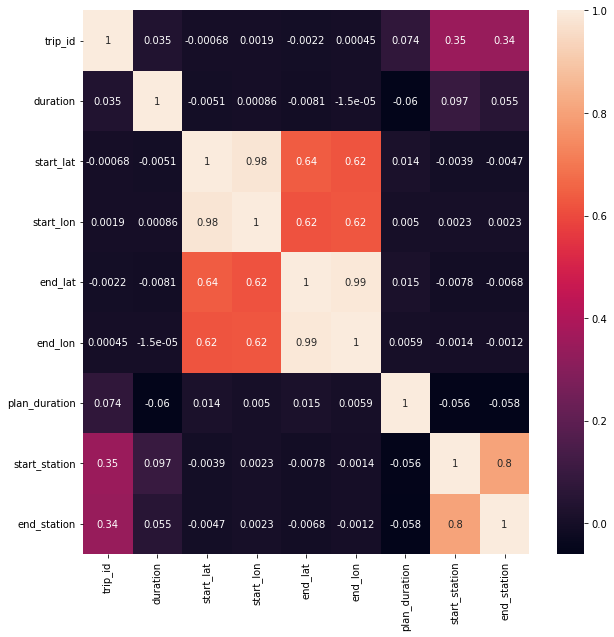

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(data= jdf_train_raw.corr(), annot=True)
plt.show()

### Transform raw dataframe

In [12]:
jdf_train_t2 = jdataframe_raw_transform_v2(jdf_train_raw)
jdf_train_t2.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529749 entries, 1 to 699999
Data columns (total 16 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   trip_id                         529749 non-null  int64  
 1   duration                        529749 non-null  int64  
 2   start_time                      529749 non-null  object 
 3   end_time                        529749 non-null  object 
 4   bike_id                         529749 non-null  object 
 5   passholder_type                 529749 non-null  object 
 6   start_station                   529749 non-null  int64  
 7   end_station                     529749 non-null  int64  
 8   distance                        529749 non-null  float64
 9   start_time_hour                 529749 non-null  int8   
 10  start_time_weekday              529749 non-null  int8   
 11  end_time_hour                   529749 non-null  int8   
 12  end_time_weekday

,count,mean,std,min,25%,50%,75%,max
trip_id,529749.0,1.040311e+08,4.561515e+07,8.369648e+06,6.959145e+07,1.149843e+08,1.373129e+08,1.794076e+08
duration,529749.0,1.391117e+01,1.076006e+01,1.000000e+00,6.000000e+00,1.100000e+01,1.800000e+01,5.900000e+01
start_station,529749.0,3.396318e+03,5.771614e+02,3.005000e+03,3.030000e+03,3.055000e+03,4.166000e+03,4.594000e+03
end_station,529749.0,3.394910e+03,5.763261e+02,3.000000e+03,3.030000e+03,3.054000e+03,4.165000e+03,4.594000e+03
distance,529749.0,1.406070e+00,1.031114e+00,9.969952e-02,7.397108e-01,1.122105e+00,1.791750e+00,4.004427e+01
start_time_hour,529749.0,1.409740e+01,4.717657e+00,0.000000e+00,1.100000e+01,1.500000e+01,1.800000e+01,2.300000e+01
start_time_weekday,529749.0,2.904253e+00,1.944781e+00,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00
end_time_hour,529749.0,1.425406e+01,4.771341e+00,0.000000e+00,1.100000e+01,1.500000e+01,1.800000e+01,2.300000e+01
end_time_weekday,529749.0,2.904768e+00,1.945581e+00,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00
trip_route_category_One Way,529749.0,9.999226e-01,8.797119e-03,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [85]:
#jdf_train_t3.sample(n=5)
jdf_train_t3.iloc[0]['start_station']

numpy.int64

In [14]:
jdf_train_t2.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'bike_id',
       'passholder_type', 'start_station', 'end_station', 'distance',
       'start_time_hour', 'start_time_weekday', 'end_time_hour',
       'end_time_weekday', 'trip_route_category_One Way',
       'trip_route_category_Round Trip', 'passholder_type_t'],
      dtype='object')

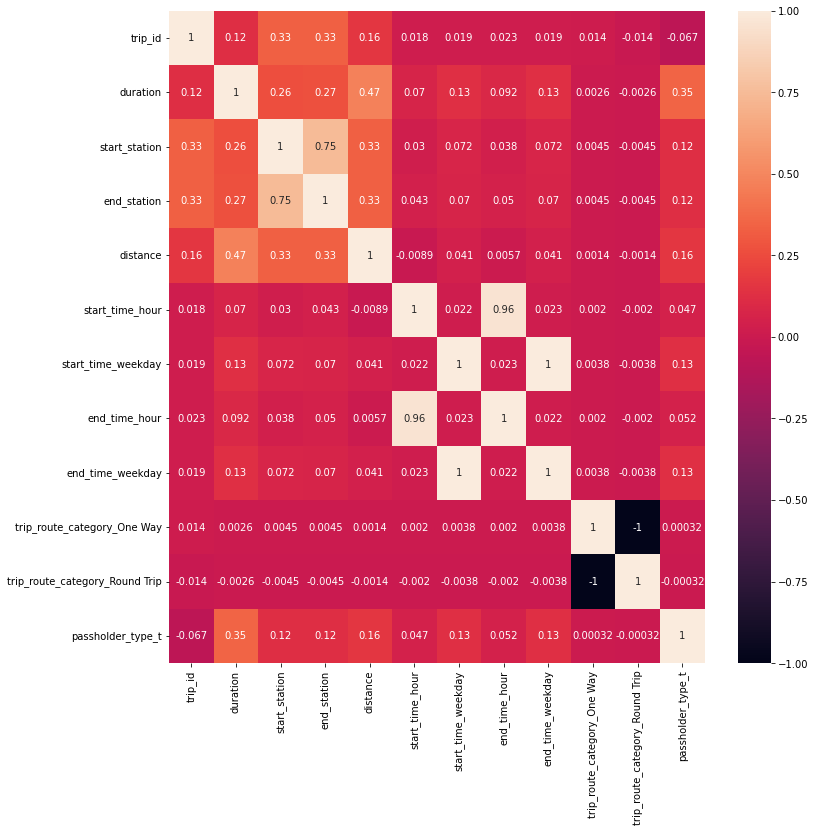

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(data= jdf_train_t2.corr(), annot=True)
plt.show()

Apply transformation 2: One Hot Encoding and delete "correlated" columns

In [109]:
jdf_train_t3 = jdataframe_raw_OneHotEnoding_transform(jdf_train_raw)
jdf_train_t3.columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529749 entries, 1 to 699999
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   trip_id                         529749 non-null  int64  
 1   duration                        529749 non-null  int64  
 2   start_time                      529749 non-null  object 
 3   end_time                        529749 non-null  object 
 4   bike_id                         529749 non-null  object 
 5   passholder_type                 529749 non-null  object 
 6   start_station                   529749 non-null  int64  
 7   end_station                     529749 non-null  int64  
 8   distance                        529749 non-null  float64
 9   trip_route_category_One Way     529749 non-null  uint8  
 10  trip_route_category_Round Trip  529749 non-null  uint8  
 11  passholder_type_t               529749 non-null  int32  
 12  start_time_hour_

Index(['trip_id', 'duration', 'start_time', 'end_time', 'bike_id',
       'passholder_type', 'start_station', 'end_station', 'distance',
       'trip_route_category_One Way', 'trip_route_category_Round Trip',
       'passholder_type_t', 'start_time_hour_0', 'start_time_hour_1',
       'start_time_hour_2', 'start_time_hour_3', 'start_time_hour_4',
       'start_time_hour_5', 'start_time_hour_6', 'start_time_hour_7',
       'start_time_hour_8', 'start_time_hour_9', 'start_time_hour_10',
       'start_time_hour_11', 'start_time_hour_12', 'start_time_hour_13',
       'start_time_hour_14', 'start_time_hour_15', 'start_time_hour_16',
       'start_time_hour_17', 'start_time_hour_18', 'start_time_hour_19',
       'start_time_hour_20', 'start_time_hour_21', 'start_time_hour_22',
       'start_time_hour_23', 'start_time_weekday_0', 'start_time_weekday_1',
       'start_time_weekday_2', 'start_time_weekday_3', 'start_time_weekday_4',
       'start_time_weekday_5', 'start_time_weekday_6'],
      

In [ ]:
jdf_train_t3['station_diff'].value_counts()

In [64]:
np.where(jdf_train_t3['start_station'].astype('int32') == jdf_train_t3['end_station'].astype('int32'), 1, 0)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
jdf_train_t3.sample(n=10)

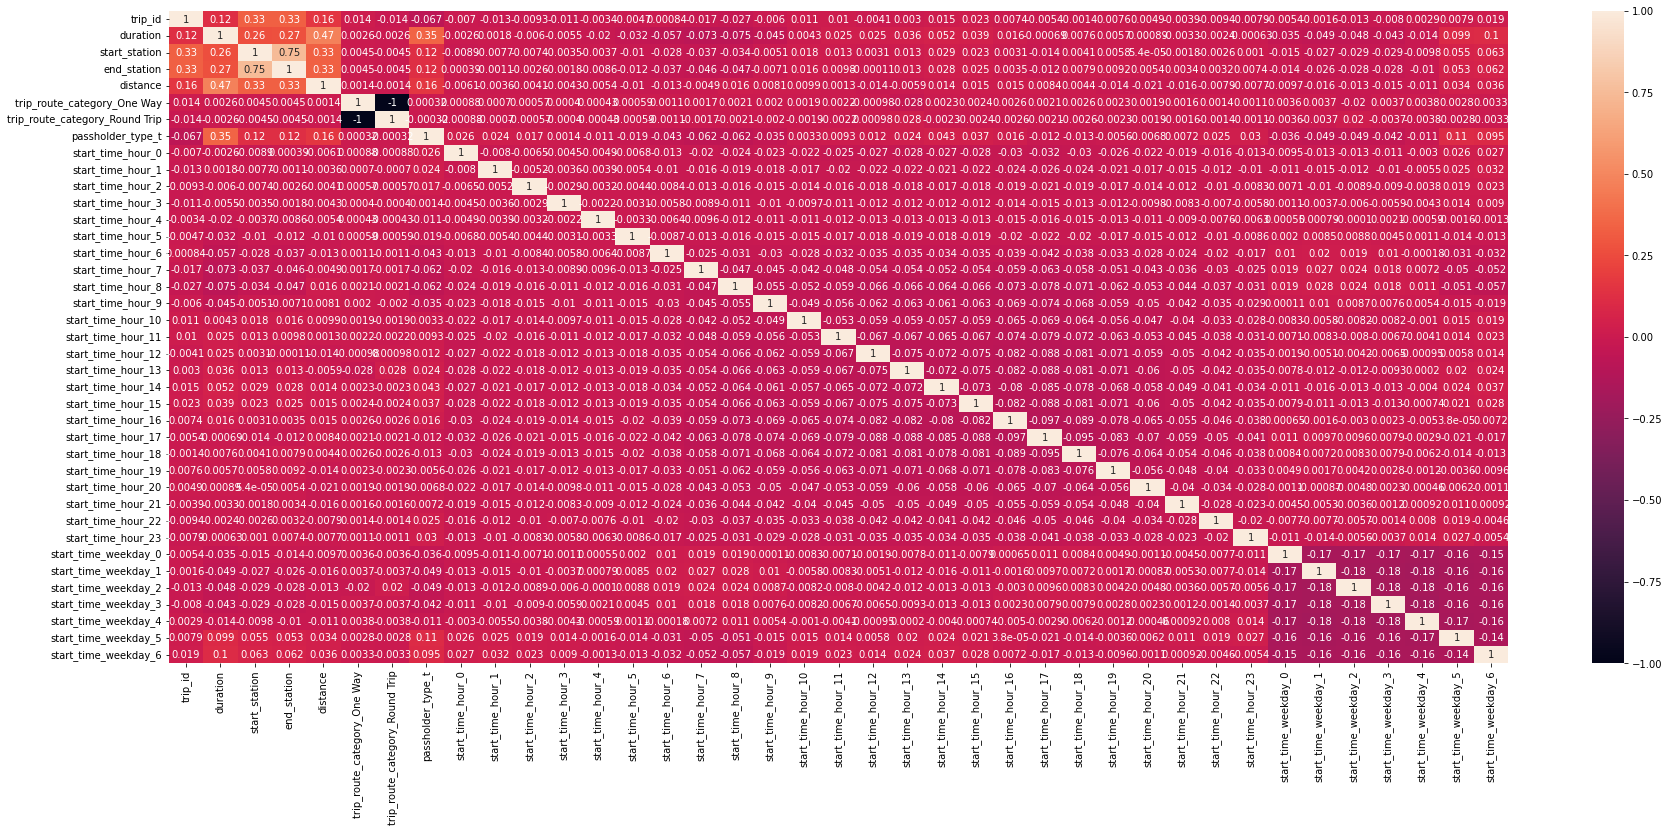

In [112]:
plt.figure(figsize=(30,12))
sns.heatmap(data= jdf_train_t3.corr(), annot=True)
plt.show()

In [ ]:
# IMBALANCE DATASET:
print(jdf_train_t2['trip_route_category'].value_counts())

jfig, jax = plt.subplots(figsize=(12,8))
jdf_train_t2['trip_route_category'].value_counts().plot(kind='barh', ax=jax)
jax.bar_label(jax.containers[0])

2    346731
5    119961
0     30011
3     22378
1     10657
4        11
Name: passholder_type_t, dtype: int64


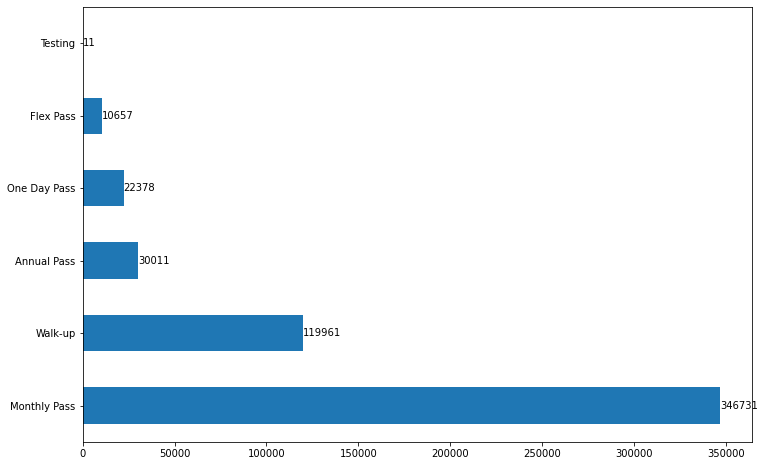

In [117]:
# IMBALANCE DATASET:
print(jdf_train_t2['passholder_type_t'].value_counts())

jfig, jax = plt.subplots(figsize=(12,8))
jdf_train_t3['passholder_type'].value_counts().plot(kind='barh', ax=jax)
jax.bar_label(jax.containers[0])
plt.show()

In [118]:
print(jdf_train_t3['trip_route_category_One Way'].value_counts())
print(jdf_train_t3['trip_route_category_Round Trip'].value_counts())

1    529708
0        41
Name: trip_route_category_One Way, dtype: int64
0    529708
1        41
Name: trip_route_category_Round Trip, dtype: int64


### transform dataframe columns

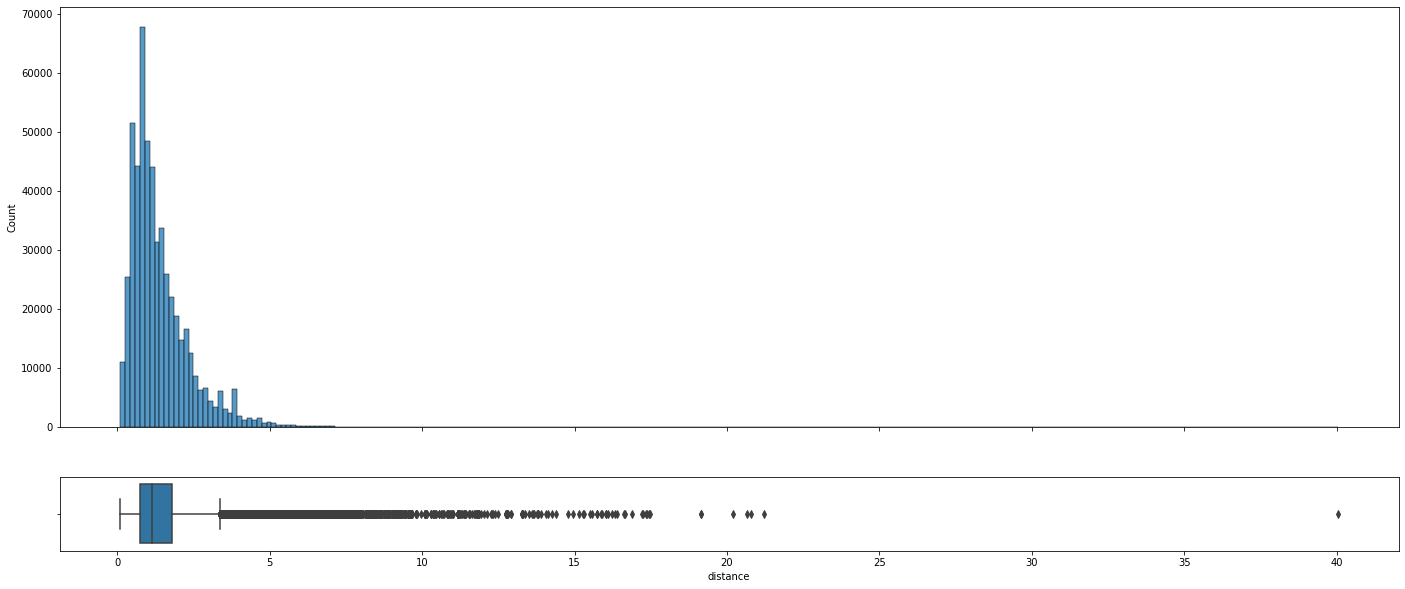

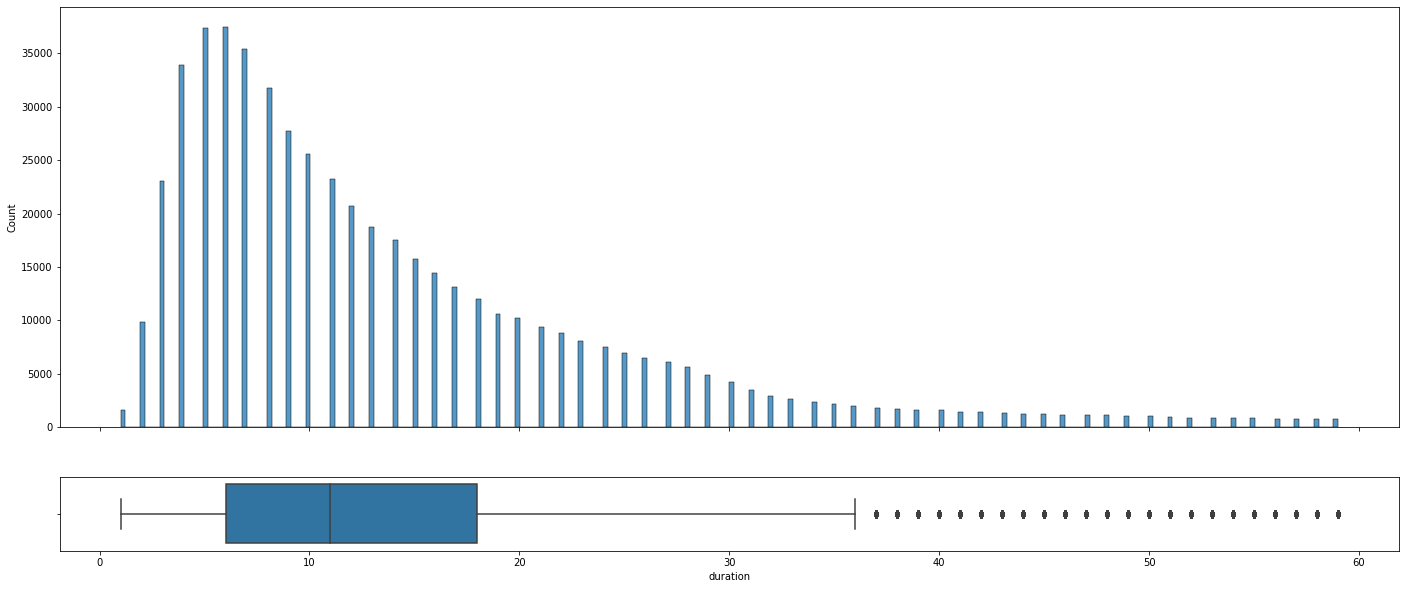

In [119]:
def jexplore_fields_with_possible_outliers():
    jbins = 250

    jfig, (jax_hist, jax_box) = plt.subplots(2, sharex=True, figsize=(24,10), gridspec_kw={'height_ratios': (.85, .15)})
    sns.histplot(jdf_train_t3['distance'], bins=jbins, ax=jax_hist)
    sns.boxplot(x=jdf_train_t3['distance'], ax=jax_box)

    jfig, (jax_hist, jax_box) = plt.subplots(2, sharex=True, figsize=(24,10), gridspec_kw={'height_ratios': (.85, .15)})
    sns.histplot(jdf_train_t3['duration'], bins=jbins, ax=jax_hist)
    sns.boxplot(x=jdf_train_t3['duration'], ax=jax_box) 
jexplore_fields_with_possible_outliers()

In [120]:
jdf_train_t3.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'bike_id',
       'passholder_type', 'start_station', 'end_station', 'distance',
       'trip_route_category_One Way', 'trip_route_category_Round Trip',
       'passholder_type_t', 'start_time_hour_0', 'start_time_hour_1',
       'start_time_hour_2', 'start_time_hour_3', 'start_time_hour_4',
       'start_time_hour_5', 'start_time_hour_6', 'start_time_hour_7',
       'start_time_hour_8', 'start_time_hour_9', 'start_time_hour_10',
       'start_time_hour_11', 'start_time_hour_12', 'start_time_hour_13',
       'start_time_hour_14', 'start_time_hour_15', 'start_time_hour_16',
       'start_time_hour_17', 'start_time_hour_18', 'start_time_hour_19',
       'start_time_hour_20', 'start_time_hour_21', 'start_time_hour_22',
       'start_time_hour_23', 'start_time_weekday_0', 'start_time_weekday_1',
       'start_time_weekday_2', 'start_time_weekday_3', 'start_time_weekday_4',
       'start_time_weekday_5', 'start_time_weekday_6'],
      

In [121]:
# drop text columns to apply SMOTETomek to process imbalanced dataset
jdf_train_t4 = jdf_train_t3.drop(columns=['start_time', 'end_time', 'bike_id', 'passholder_type']) #, 'trip_route_category'])
jdf_train_t4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 529749 entries, 1 to 699999
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   trip_id                         529749 non-null  int64  
 1   duration                        529749 non-null  int64  
 2   start_station                   529749 non-null  int64  
 3   end_station                     529749 non-null  int64  
 4   distance                        529749 non-null  float64
 5   trip_route_category_One Way     529749 non-null  uint8  
 6   trip_route_category_Round Trip  529749 non-null  uint8  
 7   passholder_type_t               529749 non-null  int32  
 8   start_time_hour_0               529749 non-null  uint8  
 9   start_time_hour_1               529749 non-null  uint8  
 10  start_time_hour_2               529749 non-null  uint8  
 11  start_time_hour_3               529749 non-null  uint8  
 12  start_time_hour_

### fix trip_route_category imbalance

In [38]:
print(jX_resampled_trip_route_category.shape), print(jy_resampled_trip_route_category.shape)

(912086, 10)
(912086,)


(None, None)

0    457424
1    454662
Name: trip_route_category_t, dtype: int64


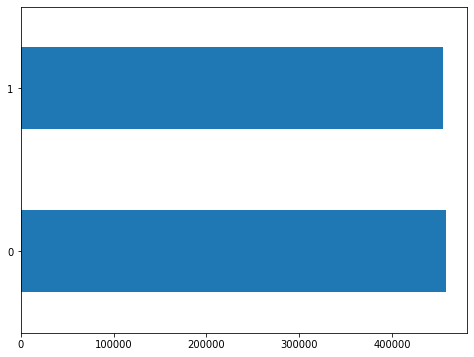

In [39]:
# IMBALANCE DATASET:
print(jy_resampled_trip_route_category.value_counts())

jfig, jax = plt.subplots(figsize=(8,6))
jy_resampled_trip_route_category.value_counts().plot(kind='barh', ax=jax)
#jax.bar_label(jax.containers[0])
plt.show()

In [40]:
# CREATE DATASET WITH THE trip_route_category BALANCED
jdf_train_t4 = jX_resampled_trip_route_category.copy()
jdf_train_t4['trip_route_category_t'] = jy_resampled_trip_route_category.copy()
print(jdf_train_t4.shape)
jdf_train_t4.sample(n=5)

(912086, 11)


,trip_id,duration,start_station,end_station,distance,start_time_hour,start_time_weekday,end_time_hour,end_time_weekday,passholder_type_t,trip_route_category_t
519707,28738335,3,3045,3020,0.559348,13,2,13,2,2,1
101637,21260616,16,3027,3036,1.804928,9,5,9,5,5,0
797556,28738330,13,3006,3020,1.875501,13,2,13,2,2,1
101430,162188389,8,3074,3025,1.409732,6,1,6,1,2,0
376842,132803387,11,3067,3035,1.049793,9,6,10,6,5,0


In [ ]:
# IMBALANCE DATASET:
print(jdf_train_t4['passholder_type_t'].value_counts())

jfig, jax = plt.subplots(figsize=(12,8))
jdf_train_t4['passholder_type_t'].value_counts().plot(kind='barh', ax=jax)
jax.bar_label(jax.containers[0])
plt.show()

### fix passholder_type imbalance

In [123]:
jdf_train_t4.columns

Index(['trip_id', 'duration', 'start_station', 'end_station', 'distance',
       'trip_route_category_One Way', 'trip_route_category_Round Trip',
       'passholder_type_t', 'start_time_hour_0', 'start_time_hour_1',
       'start_time_hour_2', 'start_time_hour_3', 'start_time_hour_4',
       'start_time_hour_5', 'start_time_hour_6', 'start_time_hour_7',
       'start_time_hour_8', 'start_time_hour_9', 'start_time_hour_10',
       'start_time_hour_11', 'start_time_hour_12', 'start_time_hour_13',
       'start_time_hour_14', 'start_time_hour_15', 'start_time_hour_16',
       'start_time_hour_17', 'start_time_hour_18', 'start_time_hour_19',
       'start_time_hour_20', 'start_time_hour_21', 'start_time_hour_22',
       'start_time_hour_23', 'start_time_weekday_0', 'start_time_weekday_1',
       'start_time_weekday_2', 'start_time_weekday_3', 'start_time_weekday_4',
       'start_time_weekday_5', 'start_time_weekday_6'],
      dtype='object')

In [124]:
# SMOTEENN
# Edited nearest neighbours
jX, jy = jX_y_create_passholder_type(jdf_train_t4)

jsmote_enn = SMOTEENN(random_state=0)
jX_resampled, jy_resampled = jsmote_enn.fit_resample(jX, jy)

In [125]:
print(jX_resampled.shape), print(jy_resampled.shape)

(1218534, 38)
(1218534,)


(None, None)

In [126]:
type(jX_resampled)

pandas.core.frame.DataFrame

In [127]:
jX_resampled.columns

Index(['trip_id', 'duration', 'start_station', 'end_station', 'distance',
       'trip_route_category_One Way', 'trip_route_category_Round Trip',
       'start_time_hour_0', 'start_time_hour_1', 'start_time_hour_2',
       'start_time_hour_3', 'start_time_hour_4', 'start_time_hour_5',
       'start_time_hour_6', 'start_time_hour_7', 'start_time_hour_8',
       'start_time_hour_9', 'start_time_hour_10', 'start_time_hour_11',
       'start_time_hour_12', 'start_time_hour_13', 'start_time_hour_14',
       'start_time_hour_15', 'start_time_hour_16', 'start_time_hour_17',
       'start_time_hour_18', 'start_time_hour_19', 'start_time_hour_20',
       'start_time_hour_21', 'start_time_hour_22', 'start_time_hour_23',
       'start_time_weekday_0', 'start_time_weekday_1', 'start_time_weekday_2',
       'start_time_weekday_3', 'start_time_weekday_4', 'start_time_weekday_5',
       'start_time_weekday_6'],
      dtype='object')

In [26]:
type(jy_resampled)

pandas.core.series.Series

4    308887
1    251324
3    217959
0    194326
5    150960
2     95078
Name: passholder_type_t, dtype: int64


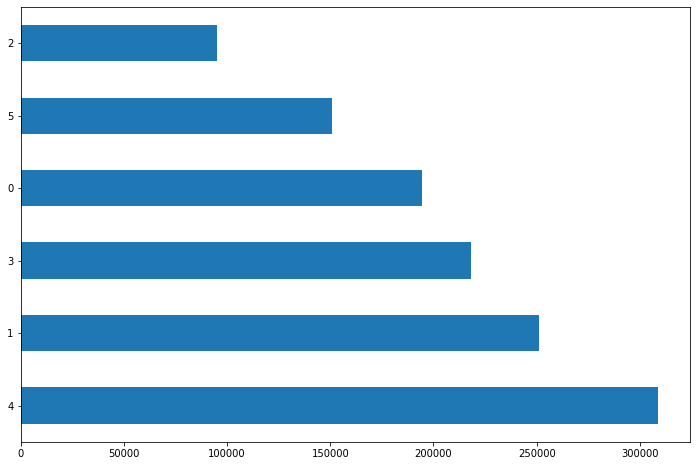

In [128]:
# IMBALANCE DATASET:
print(jy_resampled.value_counts())

jfig, jax = plt.subplots(figsize=(12,8))
jy_resampled.value_counts().plot(kind='barh', ax=jax)
#jax.bar_label(jax.containers[0])
plt.show()

In [ ]:
# let's see if passholder_type SMOTEENN affect trip_route_category
# IMBALANCE DATASET:
print(jX_resampled['trip_route_category_t'].value_counts())

jfig, jax = plt.subplots(figsize=(12,8))
jX_resampled['trip_route_category_t'].value_counts().plot(kind='barh', ax=jax)
jax.bar_label(jax.containers[0])

In [129]:
jX_resampled.to_csv('jdf_train_t4__jX_resampled_SMOTEENN_onehot_1.csv')

In [130]:
jy_resampled.to_csv('jdf_train_t4__jy_resampled_SMOTEENN_onehot_1.csv')

### TO DO: try undersampling 1 value of trip_route_category

### Data Modeling

In [131]:
jX_resampled.columns

Index(['trip_id', 'duration', 'start_station', 'end_station', 'distance',
       'trip_route_category_One Way', 'trip_route_category_Round Trip',
       'start_time_hour_0', 'start_time_hour_1', 'start_time_hour_2',
       'start_time_hour_3', 'start_time_hour_4', 'start_time_hour_5',
       'start_time_hour_6', 'start_time_hour_7', 'start_time_hour_8',
       'start_time_hour_9', 'start_time_hour_10', 'start_time_hour_11',
       'start_time_hour_12', 'start_time_hour_13', 'start_time_hour_14',
       'start_time_hour_15', 'start_time_hour_16', 'start_time_hour_17',
       'start_time_hour_18', 'start_time_hour_19', 'start_time_hour_20',
       'start_time_hour_21', 'start_time_hour_22', 'start_time_hour_23',
       'start_time_weekday_0', 'start_time_weekday_1', 'start_time_weekday_2',
       'start_time_weekday_3', 'start_time_weekday_4', 'start_time_weekday_5',
       'start_time_weekday_6'],
      dtype='object')

In [132]:
jX_resampled = jX_resampled.drop(columns='trip_id')

In [133]:
jX_resampled.columns

Index(['duration', 'start_station', 'end_station', 'distance',
       'trip_route_category_One Way', 'trip_route_category_Round Trip',
       'start_time_hour_0', 'start_time_hour_1', 'start_time_hour_2',
       'start_time_hour_3', 'start_time_hour_4', 'start_time_hour_5',
       'start_time_hour_6', 'start_time_hour_7', 'start_time_hour_8',
       'start_time_hour_9', 'start_time_hour_10', 'start_time_hour_11',
       'start_time_hour_12', 'start_time_hour_13', 'start_time_hour_14',
       'start_time_hour_15', 'start_time_hour_16', 'start_time_hour_17',
       'start_time_hour_18', 'start_time_hour_19', 'start_time_hour_20',
       'start_time_hour_21', 'start_time_hour_22', 'start_time_hour_23',
       'start_time_weekday_0', 'start_time_weekday_1', 'start_time_weekday_2',
       'start_time_weekday_3', 'start_time_weekday_4', 'start_time_weekday_5',
       'start_time_weekday_6'],
      dtype='object')

In [134]:
jX_train, jX_test, jy_train, jy_test, jX, jy = jtrain_test_split(jX_resampled, jy_resampled)

jRFC = RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=-1, random_state=19) #10
jRFC.fit(jX_train, jy_train)

print( jRFC.get_params(deep=True) )

jRFC_train_predictions = jRFC.predict(jX_train)
jRFC_test_predictions = jRFC.predict(jX_test)

jRFC_train_predictions_score = accuracy_score(jy_train, jRFC_train_predictions)
jRFC_test_predictions_score = accuracy_score(jy_test, jRFC_test_predictions)

print('Random Forest Classifier Train prediction Score = ', jRFC_train_predictions_score)
print('Random Forest Classifier Test prediction Score = ', jRFC_test_predictions_score)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': 19, 'verbose': 0, 'warm_start': False}
Random Forest Classifier Train prediction Score =  0.6648502759976899
Random Forest Classifier Test prediction Score =  0.6622378511901587


Test dataset

In [135]:
jdf_test.columns

Index(['trip_id', 'duration', 'start_time', 'end_time', 'start_lat',
       'start_lon', 'end_lat', 'end_lon', 'bike_id', 'trip_route_category',
       'start_station', 'end_station'],
      dtype='object')

In [136]:
#jX_test_set_file = jdataframe_raw_transform(jdf_test, jis_test_dataset= 1)
jX_test_set_file = jdataframe_raw_OneHotEnoding_transform(jdf_test, jis_test_dataset= 1)
jX_test_set_file = jX_test_set_file.drop(columns=['start_time', 'end_time', 'bike_id', 'trip_id']) #, 'trip_route_category'])
jX_test_set_file.fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569886 entries, 0 to 569885
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   trip_id                         569886 non-null  int64  
 1   duration                        569886 non-null  int64  
 2   start_time                      569886 non-null  object 
 3   end_time                        569886 non-null  object 
 4   bike_id                         569886 non-null  object 
 5   start_station                   569886 non-null  int64  
 6   end_station                     569886 non-null  int64  
 7   distance                        552421 non-null  float64
 8   trip_route_category_One Way     569886 non-null  uint8  
 9   trip_route_category_Round Trip  569886 non-null  uint8  
 10  start_time_hour_0               569886 non-null  uint8  
 11  start_time_hour_1               569886 non-null  uint8  
 12  start_time_hour_

In [137]:
jX_test_set_file.isnull().sum()

duration                          0
start_station                     0
end_station                       0
distance                          0
trip_route_category_One Way       0
trip_route_category_Round Trip    0
start_time_hour_0                 0
start_time_hour_1                 0
start_time_hour_2                 0
start_time_hour_3                 0
start_time_hour_4                 0
start_time_hour_5                 0
start_time_hour_6                 0
start_time_hour_7                 0
start_time_hour_8                 0
start_time_hour_9                 0
start_time_hour_10                0
start_time_hour_11                0
start_time_hour_12                0
start_time_hour_13                0
start_time_hour_14                0
start_time_hour_15                0
start_time_hour_16                0
start_time_hour_17                0
start_time_hour_18                0
start_time_hour_19                0
start_time_hour_20                0
start_time_hour_21          

In [138]:
jX_test_set_file.columns

Index(['duration', 'start_station', 'end_station', 'distance',
       'trip_route_category_One Way', 'trip_route_category_Round Trip',
       'start_time_hour_0', 'start_time_hour_1', 'start_time_hour_2',
       'start_time_hour_3', 'start_time_hour_4', 'start_time_hour_5',
       'start_time_hour_6', 'start_time_hour_7', 'start_time_hour_8',
       'start_time_hour_9', 'start_time_hour_10', 'start_time_hour_11',
       'start_time_hour_12', 'start_time_hour_13', 'start_time_hour_14',
       'start_time_hour_15', 'start_time_hour_16', 'start_time_hour_17',
       'start_time_hour_18', 'start_time_hour_19', 'start_time_hour_20',
       'start_time_hour_21', 'start_time_hour_22', 'start_time_hour_23',
       'start_time_weekday_0', 'start_time_weekday_1', 'start_time_weekday_2',
       'start_time_weekday_3', 'start_time_weekday_4', 'start_time_weekday_5',
       'start_time_weekday_6'],
      dtype='object')

In [139]:
jX_train.columns

Index(['duration', 'start_station', 'end_station', 'distance',
       'trip_route_category_One Way', 'trip_route_category_Round Trip',
       'start_time_hour_0', 'start_time_hour_1', 'start_time_hour_2',
       'start_time_hour_3', 'start_time_hour_4', 'start_time_hour_5',
       'start_time_hour_6', 'start_time_hour_7', 'start_time_hour_8',
       'start_time_hour_9', 'start_time_hour_10', 'start_time_hour_11',
       'start_time_hour_12', 'start_time_hour_13', 'start_time_hour_14',
       'start_time_hour_15', 'start_time_hour_16', 'start_time_hour_17',
       'start_time_hour_18', 'start_time_hour_19', 'start_time_hour_20',
       'start_time_hour_21', 'start_time_hour_22', 'start_time_hour_23',
       'start_time_weekday_0', 'start_time_weekday_1', 'start_time_weekday_2',
       'start_time_weekday_3', 'start_time_weekday_4', 'start_time_weekday_5',
       'start_time_weekday_6'],
      dtype='object')

### Test set file

In [29]:
jX_test_set_file.columns

Index(['duration', 'start_station', 'end_station', 'distance',
       'start_time_hour', 'start_time_weekday', 'end_time_hour',
       'end_time_weekday', 'trip_route_category_One Way',
       'trip_route_category_Round Trip'],
      dtype='object')

In [140]:
# create submission file
jX_test_set_file_predictions = jRFC.predict(jX_test_set_file)
jX_test_set_file['passholder_type_number'] = jX_test_set_file_predictions


jX_test_set_file['passholder_type'] = np.where(jX_test_set_file['passholder_type_number']==0, 'Annual Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==1, 'Flex Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==2, 'Monthly Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==3, 'One Day Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==4, 'Testing', 'Walk-up')))))

jX_test_set_file_final = jX_test_set_file.drop(columns=['passholder_type_number'])
jX_test_set_file_final['trip_id'] = jdf_test['trip_id']
jX_test_set_file_final[['trip_id', 'passholder_type']].to_csv('jRFC_model_onehot_1.csv', index=None)

In [77]:
jX_test_set_file.sample(n=5)

,trip_id,duration,start_lat,start_lon,end_lat,end_lon,start_station,end_station,distance,start_time_hour,start_time_weekday,end_time_hour,end_time_weekday,trip_route_category_One Way,trip_route_category_Round Trip,passholder_type_number
51923,14259580,6,34.042061,-118.263382,34.049889,-118.255882,3034,3032,1.111374,10,2,10,2,1,0,1
396144,135428417,25,34.048500,-118.258537,34.044701,-118.252441,3005,3031,0.702778,14,4,14,4,1,0,2
274074,115395154,4,34.044701,-118.252441,34.046822,-118.248352,3031,3038,0.444473,19,1,19,1,1,0,0
320498,125173162,11,34.042061,-118.263382,34.049301,-118.238808,3034,3042,2.402996,16,1,17,1,1,0,0
544607,168642658,15,34.048401,-118.260948,34.048870,-118.274300,3035,4300,1.231251,17,4,17,4,1,0,0


<AxesSubplot:>

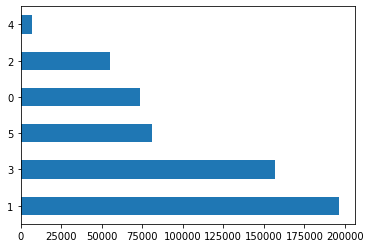

In [141]:
jX_test_set_file['passholder_type_number'].value_counts().plot(kind='barh')

In [ ]:
def jpassholder_type_number_TO_TEXT(jpassholder_type_number_value):
    pass

jX_test_set_file['passholder_type'] = np.where(jX_test_set_file['passholder_type_number']==0, 'Annual Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==1, 'Flex Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==2, 'Monthly Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==3, 'One Day Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==4, 'Testing', 'Walk-up')))))

jX_test_set_file_final = jX_test_set_file.drop(columns=['passholder_type_number'])


### hyperparameter tunning 

In [31]:
jn_estimators = list(range(10,160,50))
jcriterion_list = ['gini', 'entropy']
jmax_depth_list = list(range(5,41,10))
jmax_depth_list.append(None)
jmin_samples_split_list = [jx/1000 for jx in list(range(5,41,10))]
jmin_samples_leaf_list = [jx/1000 for jx in list(range(5,41,10))]
jmax_features_list = ['sqrt', 'log2']

jparams_grid = {
    'n_estimators': jn_estimators,
    'criterion': jcriterion_list,
    'max_depth': jmax_depth_list,
    'min_samples_split': jmin_samples_split_list,
    'min_samples_leaf': jmin_samples_leaf_list,
    'max_features': jmax_features_list
}

# total combinations:
jtotal_combinations = 1
for jx in jparams_grid.keys():
    jtotal_combinations *= len(jparams_grid[jx])

print('Number of total combinations = ', jtotal_combinations)
jparams_grid

Number of total combinations =  960


{'n_estimators': [10, 60, 110],
 'criterion': ['gini', 'entropy'],
 'max_depth': [5, 15, 25, 35, None],
 'min_samples_split': [0.005, 0.015, 0.025, 0.035],
 'min_samples_leaf': [0.005, 0.015, 0.025, 0.035],
 'max_features': ['sqrt', 'log2']}

In [ ]:
jX_train, jX_test, jy_train, jy_test, jX, jy = jtrain_test_split(jX_resampled, jy_resampled)

jrandom_cv = RandomizedSearchCV(
    estimator = RandomForestClassifier(n_jobs=-1),
    param_distributions = jparams_grid,
    scoring = "accuracy",
    n_iter = 80,
    cv = 3,
    return_train_score = True,
    verbose = 2
)
jrandom_cv.fit(jX_train, jy_train)

In [33]:
jrandom_cv.best_params_

{'n_estimators': 110,
 'min_samples_split': 0.005,
 'min_samples_leaf': 0.005,
 'max_features': 'sqrt',
 'max_depth': 35,
 'criterion': 'gini'}

In [ ]:
"""
{'n_estimators': 110,
 'min_samples_split': 0.005,
 'min_samples_leaf': 0.005,
 'max_features': 'sqrt',
 'max_depth': 35,
 'criterion': 'gini'}
"""

Using the best parameters

In [27]:
jX_train, jX_test, jy_train, jy_test, jX, jy = jtrain_test_split(jX_resampled, jy_resampled)

jRFC = RandomForestClassifier(n_estimators=110, 
                                min_samples_split = 0.005,
                                min_samples_leaf= 0.005,
                                max_features='sqrt',
                                max_depth=35, criterion='gini', 
                                n_jobs=-1, random_state=19)
jRFC.fit(jX_train, jy_train)

print( jRFC.get_params(deep=True) )

jRFC_train_predictions = jRFC.predict(jX_train)
jRFC_test_predictions = jRFC.predict(jX_test)

jRFC_train_predictions_score = accuracy_score(jy_train, jRFC_train_predictions)
jRFC_test_predictions_score = accuracy_score(jy_test, jRFC_test_predictions)

print('Random Forest Classifier Train prediction Score = ', jRFC_train_predictions_score)
print('Random Forest Classifier Test prediction Score = ', jRFC_test_predictions_score)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 35, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 0.005, 'min_samples_split': 0.005, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 110, 'n_jobs': -1, 'oob_score': False, 'random_state': 19, 'verbose': 0, 'warm_start': False}
Random Forest Classifier Train prediction Score =  0.6457782071636329
Random Forest Classifier Test prediction Score =  0.6460452904496226


### XGBoost Classifier

In [144]:
jX_train, jX_test, jy_train, jy_test, jX, jy = jtrain_test_split(jX_resampled, jy_resampled)

jxbgc = XGBClassifier()
jxbgc.fit(jX_train, jy_train)


print( jxbgc.get_params() )

jxbgc_train_predictions = jxbgc.predict(jX_train)
jxbgc_test_predictions = jxbgc.predict(jX_test)

jxbgc_train_predictions_score = accuracy_score(jy_train, jxbgc_train_predictions)
jxbgc_test_predictions_score = accuracy_score(jy_test, jxbgc_test_predictions)

print('Random Forest Classifier Train prediction Score = ', jxbgc_train_predictions_score)
print('Random Forest Classifier Test prediction Score = ', jxbgc_test_predictions_score)

c:\jvenv_datascience_2021\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:02:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'objective': 'multi:softprob', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.300000012, 'max_delta_step': 0, 'max_depth': 6, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 100, 'n_jobs': 8, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': None, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Random Forest Classifier Train 

test set file data

In [145]:
jX_test_set_file = jdataframe_raw_OneHotEnoding_transform(jdf_test, jis_test_dataset= 1)
jX_test_set_file = jX_test_set_file.drop(columns=['start_time', 'end_time', 'bike_id', 'trip_id']) #, 'trip_route_category'])
jX_test_set_file.fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569886 entries, 0 to 569885
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   trip_id                         569886 non-null  int64  
 1   duration                        569886 non-null  int64  
 2   start_time                      569886 non-null  object 
 3   end_time                        569886 non-null  object 
 4   bike_id                         569886 non-null  object 
 5   start_station                   569886 non-null  int64  
 6   end_station                     569886 non-null  int64  
 7   distance                        552421 non-null  float64
 8   trip_route_category_One Way     569886 non-null  uint8  
 9   trip_route_category_Round Trip  569886 non-null  uint8  
 10  start_time_hour_0               569886 non-null  uint8  
 11  start_time_hour_1               569886 non-null  uint8  
 12  start_time_hour_

In [146]:
# create submission file
jX_test_set_file_predictions = jxbgc.predict(jX_test_set_file)
jX_test_set_file['passholder_type_number'] = jX_test_set_file_predictions


jX_test_set_file['passholder_type'] = np.where(jX_test_set_file['passholder_type_number']==0, 'Annual Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==1, 'Flex Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==2, 'Monthly Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==3, 'One Day Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==4, 'Testing', 'Walk-up')))))

jX_test_set_file_final = jX_test_set_file.drop(columns=['passholder_type_number'])
jX_test_set_file_final['trip_id'] = jdf_test['trip_id']
jX_test_set_file_final[['trip_id', 'passholder_type']].to_csv('jxbgc_model_onehot_1.csv', index=None)

XGBClassifier score: 0.4939

### CatBoost

In [ ]:
#jX_resampled = pd.read_csv('jdf_train_t4__jX_resampled_SMOTEENN_onehot_1.csv')
#jy_resampled = pd.read_csv('jdf_train_t4__jy_resampled_SMOTEENN_onehot_1.csv')

In [151]:
jX_train, jX_test, jy_train, jy_test, jX, jy = jtrain_test_split(jX_resampled, jy_resampled)

#jRFC = RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=-1, random_state=19) #10
jcbc = CatBoostClassifier(iterations=1000, eval_metric = 'Accuracy', learning_rate=0.1, verbose = 500)
jcbc.fit(jX_train, jy_train)


print( jcbc.get_params() )

jcbc_train_predictions = jcbc.predict(jX_train)
jcbc_test_predictions = jcbc.predict(jX_test)

jcbc_train_predictions_score = accuracy_score(jy_train, jcbc_train_predictions)
jcbc_test_predictions_score = accuracy_score(jy_test, jcbc_test_predictions)

print('CatBoost Classifier Train prediction Score = ', jcbc_train_predictions_score)
print('CatBoost Classifier Test prediction Score = ', jcbc_test_predictions_score)

0:	learn: 0.5840749	total: 500ms	remaining: 8m 19s
500:	learn: 0.7317657	total: 2m 57s	remaining: 2m 56s
999:	learn: 0.7471613	total: 6m 2s	remaining: 0us
{'iterations': 1000, 'learning_rate': 0.1, 'verbose': 500, 'eval_metric': 'Accuracy'}
CatBoost Classifier Train prediction Score =  0.7471612911829484
CatBoost Classifier Test prediction Score =  0.7407214400899441


otra ejecución con 10,000 iteraciones

In [152]:
jX_train, jX_test, jy_train, jy_test, jX, jy = jtrain_test_split(jX_resampled, jy_resampled)

#jRFC = RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=-1, random_state=19) #10
jcbc2 = CatBoostClassifier(iterations=10000, eval_metric = 'Accuracy', learning_rate=0.1, verbose = 500)
jcbc2.fit(jX_train, jy_train)


print( jcbc2.get_params() )

jcbc2_train_predictions = jcbc2.predict(jX_train)
jcbc2_test_predictions = jcbc2.predict(jX_test)

jcbc2_train_predictions_score = accuracy_score(jy_train, jcbc2_train_predictions)
jcbc2_test_predictions_score = accuracy_score(jy_test, jcbc2_test_predictions)

print('CatBoost Classifier Train prediction Score = ', jcbc2_train_predictions_score)
print('CatBoost Classifier Test prediction Score = ', jcbc2_test_predictions_score)

0:	learn: 0.5840749	total: 393ms	remaining: 1h 5m 29s
500:	learn: 0.7317657	total: 3m 14s	remaining: 1h 1m 35s
1000:	learn: 0.7471910	total: 6m 29s	remaining: 58m 22s
1500:	learn: 0.7572041	total: 9m 40s	remaining: 54m 44s
2000:	learn: 0.7648383	total: 12m 46s	remaining: 51m 4s
2500:	learn: 0.7710209	total: 15m 54s	remaining: 47m 41s
3000:	learn: 0.7762895	total: 19m 3s	remaining: 44m 26s
3500:	learn: 0.7808237	total: 22m 13s	remaining: 41m 15s
4000:	learn: 0.7850070	total: 25m 26s	remaining: 38m 8s
4500:	learn: 0.7888302	total: 28m 40s	remaining: 35m 2s
5000:	learn: 0.7921857	total: 31m 53s	remaining: 31m 52s
5500:	learn: 0.7954396	total: 35m 2s	remaining: 28m 39s
6000:	learn: 0.7984463	total: 38m 11s	remaining: 25m 26s
6500:	learn: 0.8013217	total: 41m 25s	remaining: 22m 17s
7000:	learn: 0.8038226	total: 44m 45s	remaining: 19m 10s
7500:	learn: 0.8064416	total: 48m 8s	remaining: 16m 2s
8000:	learn: 0.8088020	total: 51m 22s	remaining: 12m 50s
8500:	learn: 0.8112219	total: 54m 32s	remai

Test set file

In [153]:
jX_test_set_file = jdataframe_raw_OneHotEnoding_transform(jdf_test, jis_test_dataset= 1)
jX_test_set_file = jX_test_set_file.drop(columns=['start_time', 'end_time', 'bike_id', 'trip_id']) #, 'trip_route_category'])
jX_test_set_file.fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569886 entries, 0 to 569885
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   trip_id                         569886 non-null  int64  
 1   duration                        569886 non-null  int64  
 2   start_time                      569886 non-null  object 
 3   end_time                        569886 non-null  object 
 4   bike_id                         569886 non-null  object 
 5   start_station                   569886 non-null  int64  
 6   end_station                     569886 non-null  int64  
 7   distance                        552421 non-null  float64
 8   trip_route_category_One Way     569886 non-null  uint8  
 9   trip_route_category_Round Trip  569886 non-null  uint8  
 10  start_time_hour_0               569886 non-null  uint8  
 11  start_time_hour_1               569886 non-null  uint8  
 12  start_time_hour_

In [154]:
# create submission file
jX_test_set_file_predictions = jcbc2.predict(jX_test_set_file)
jX_test_set_file['passholder_type_number'] = jX_test_set_file_predictions


jX_test_set_file['passholder_type'] = np.where(jX_test_set_file['passholder_type_number']==0, 'Annual Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==1, 'Flex Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==2, 'Monthly Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==3, 'One Day Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==4, 'Testing', 'Walk-up')))))

jX_test_set_file_final = jX_test_set_file.drop(columns=['passholder_type_number'])
jX_test_set_file_final['trip_id'] = jdf_test['trip_id']
jX_test_set_file_final[['trip_id', 'passholder_type']].to_csv('jcbc2_model_onehot_2.csv', index=None)

3ra ejecucion

In [155]:
jX_train, jX_test, jy_train, jy_test, jX, jy = jtrain_test_split(jX_resampled, jy_resampled)

jcbc3 = CatBoostClassifier(iterations=13000, eval_metric = 'Accuracy', learning_rate=0.1, verbose = 500)
jcbc3.fit(jX_train, jy_train)


print( jcbc3.get_params() )

jcbc3_train_predictions = jcbc3.predict(jX_train)
jcbc3_test_predictions = jcbc3.predict(jX_test)

jcbc3_train_predictions_score = accuracy_score(jy_train, jcbc3_train_predictions)
jcbc3_test_predictions_score = accuracy_score(jy_test, jcbc3_test_predictions)

print('CatBoost Classifier Train prediction Score = ', jcbc3_train_predictions_score)
print('CatBoost Classifier Test prediction Score = ', jcbc3_test_predictions_score)

0:	learn: 0.5840749	total: 439ms	remaining: 1h 35m 8s
500:	learn: 0.7317657	total: 2m 54s	remaining: 1h 12m 44s
1000:	learn: 0.7471910	total: 6m 3s	remaining: 1h 12m 37s
1500:	learn: 0.7572041	total: 9m 9s	remaining: 1h 10m 13s
2000:	learn: 0.7648383	total: 12m 18s	remaining: 1h 7m 39s
2500:	learn: 0.7710209	total: 15m 34s	remaining: 1h 5m 21s
3000:	learn: 0.7762895	total: 18m 44s	remaining: 1h 2m 27s
3500:	learn: 0.7808237	total: 21m 52s	remaining: 59m 21s
4000:	learn: 0.7850070	total: 25m 2s	remaining: 56m 18s
4500:	learn: 0.7888302	total: 28m 12s	remaining: 53m 16s
5000:	learn: 0.7921857	total: 31m 23s	remaining: 50m 13s
5500:	learn: 0.7954396	total: 34m 35s	remaining: 47m 9s
6000:	learn: 0.7984463	total: 37m 46s	remaining: 44m 3s
6500:	learn: 0.8013217	total: 40m 59s	remaining: 40m 58s
7000:	learn: 0.8038226	total: 44m 9s	remaining: 37m 50s
7500:	learn: 0.8064416	total: 47m 21s	remaining: 34m 43s
8000:	learn: 0.8088020	total: 50m 37s	remaining: 31m 37s
8500:	learn: 0.8112219	total:

In [10]:
jX_test_set_file = jdataframe_raw_OneHotEnoding_transform(jdf_test, jis_test_dataset= 1)
jX_test_set_file = jX_test_set_file.drop(columns=['start_time', 'end_time', 'bike_id', 'trip_id']) #, 'trip_route_category'])
jX_test_set_file.fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569886 entries, 0 to 569885
Data columns (total 41 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   trip_id                         569886 non-null  int64  
 1   duration                        569886 non-null  int64  
 2   start_time                      569886 non-null  object 
 3   end_time                        569886 non-null  object 
 4   bike_id                         569886 non-null  object 
 5   start_station                   569886 non-null  int64  
 6   end_station                     569886 non-null  int64  
 7   distance                        552421 non-null  float64
 8   trip_route_category_One Way     569886 non-null  uint8  
 9   trip_route_category_Round Trip  569886 non-null  uint8  
 10  start_time_hour_0               569886 non-null  uint8  
 11  start_time_hour_1               569886 non-null  uint8  
 12  start_time_hour_

In [12]:
# create submission file
jX_test_set_file_predictions = jmodel_catboost13mil.predict(jX_test_set_file)
jX_test_set_file['passholder_type_number'] = jX_test_set_file_predictions


jX_test_set_file['passholder_type'] = np.where(jX_test_set_file['passholder_type_number']==0, 'Annual Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==1, 'Flex Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==2, 'Monthly Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==3, 'One Day Pass',
                                    np.where(jX_test_set_file['passholder_type_number']==4, 'Testing', 'Walk-up')))))

jX_test_set_file_final = jX_test_set_file.drop(columns=['passholder_type_number'])
jX_test_set_file_final['trip_id'] = jdf_test['trip_id']
jX_test_set_file_final[['trip_id', 'passholder_type']].to_csv('jcbc3_model_onehot_2_posttime.csv', index=None)

### SAVE ALL TRAINED MODELS

In [159]:
# to save
pickle.dump(jxbgc, open('jxbgc_7min.sav', 'wb'))
# to load
#jmodel_xgbc = pickle.load(open('jxgbc_7min.sav', 'rb'))

pickle.dump(jcbc3, open('jcatboost_13mil_83min.sav', 'wb'))
# to load
#jmodel_catboost13mil = pickle.load(open('jcatboost_13mil_83min.sav', 'rb'))


# feature importance

In [2]:
jmodel_catboost13mil = pickle.load(open('jcatboost_13mil_83min.sav', 'rb'))

In [13]:
jX_test_set_file_final.columns

Index(['duration', 'start_station', 'end_station', 'distance',
       'trip_route_category_One Way', 'trip_route_category_Round Trip',
       'start_time_hour_0', 'start_time_hour_1', 'start_time_hour_2',
       'start_time_hour_3', 'start_time_hour_4', 'start_time_hour_5',
       'start_time_hour_6', 'start_time_hour_7', 'start_time_hour_8',
       'start_time_hour_9', 'start_time_hour_10', 'start_time_hour_11',
       'start_time_hour_12', 'start_time_hour_13', 'start_time_hour_14',
       'start_time_hour_15', 'start_time_hour_16', 'start_time_hour_17',
       'start_time_hour_18', 'start_time_hour_19', 'start_time_hour_20',
       'start_time_hour_21', 'start_time_hour_22', 'start_time_hour_23',
       'start_time_weekday_0', 'start_time_weekday_1', 'start_time_weekday_2',
       'start_time_weekday_3', 'start_time_weekday_4', 'start_time_weekday_5',
       'start_time_weekday_6', 'passholder_type', 'trip_id'],
      dtype='object')

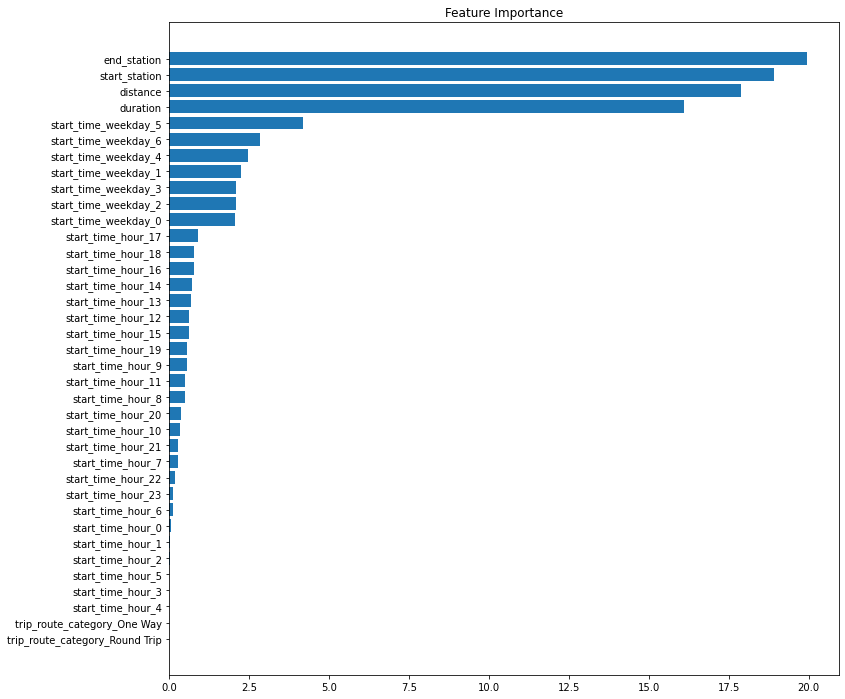

In [15]:
jfeatures = jmodel_catboost13mil.feature_importances_
jsorted_idx = np.argsort(jfeatures)
jfig = plt.figure(figsize=(12,12))
plt.barh(range(len(jsorted_idx)), jfeatures[jsorted_idx])
plt.yticks(range(len(jsorted_idx)), np.array(jX_test_set_file_final.columns)[jsorted_idx])
plt.title('Feature Importance')
plt.show()

In [22]:
jX_resampled = pd.read_csv('jdf_train_t4__jX_resampled_SMOTEENN_onehot_1.csv')
jy_resampled = pd.read_csv('jdf_train_t4__jy_resampled_SMOTEENN_onehot_1.csv')

In [23]:
jX_train, jX_test, jy_train, jy_test, jX, jy = jtrain_test_split(jX_resampled, jy_resampled)

In [32]:
jy_resampled.columns

Index(['Unnamed: 0', 'passholder_type_t'], dtype='object')

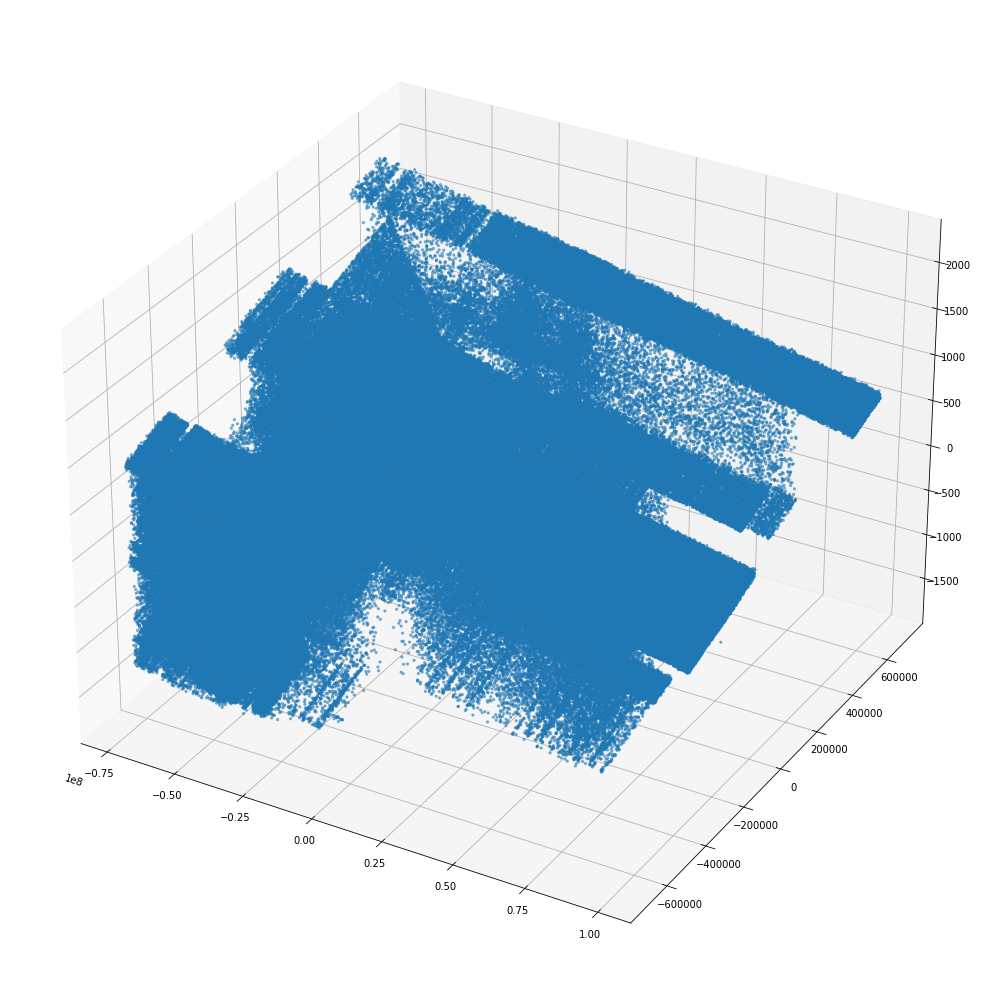

In [41]:
jX_train, jX_test, jy_train, jy_test, jX, jy = jtrain_test_split(jX_resampled, jy_resampled)
jpca2 = PCA(n_components=3)
jpca2.fit(jX_train)

jX_train_pca2 = jpca2.transform(jX_train)

plt.figure(figsize=(20,18))
ax = plt.axes(projection='3d')
ax.scatter(jX_train_pca2[:, 0], jX_train_pca2[:, 1], jX_train_pca2[:, 2], marker='.', alpha=0.5)
plt.show()

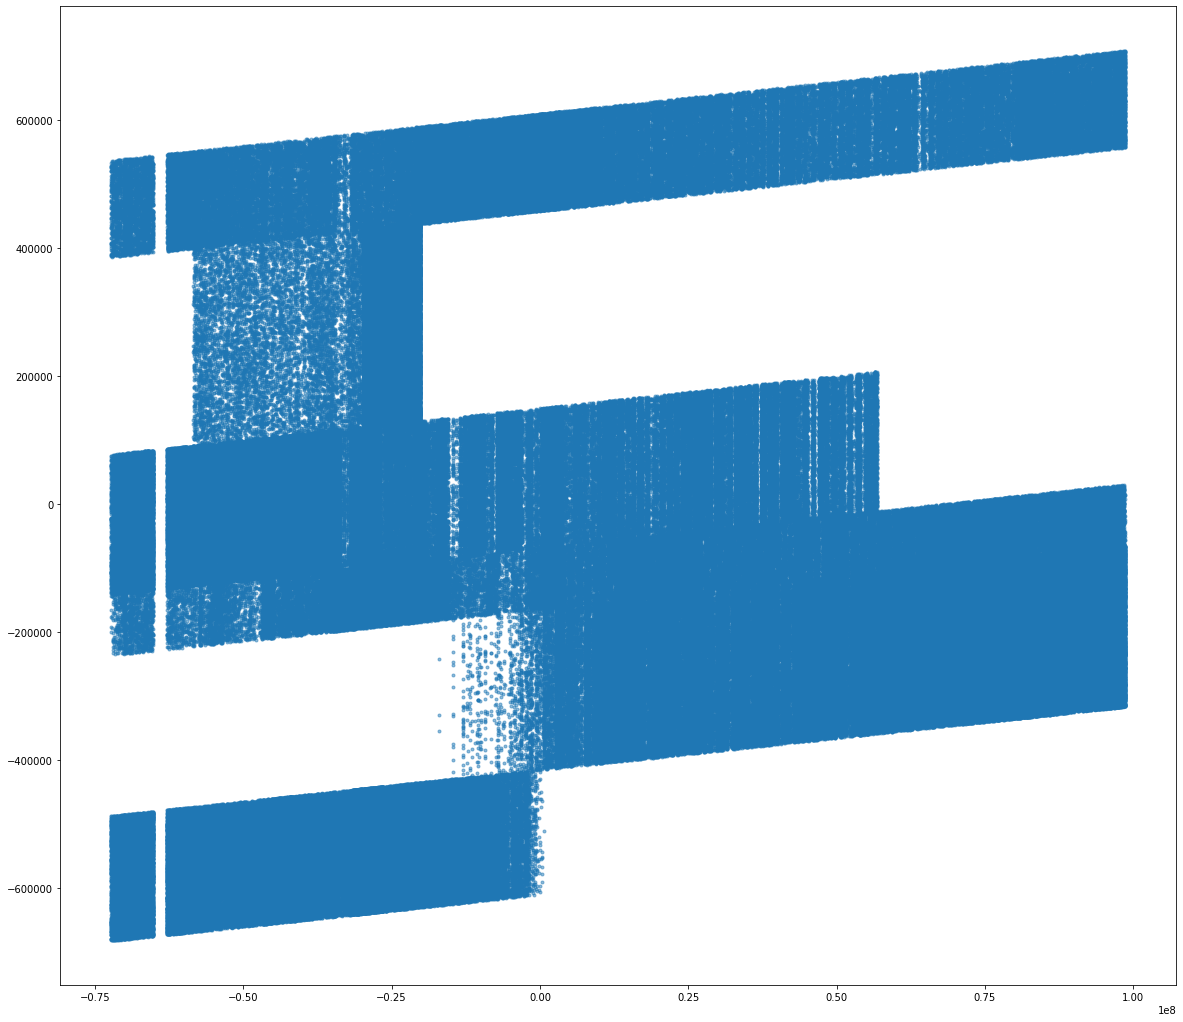

In [42]:
jX_train, jX_test, jy_train, jy_test, jX, jy = jtrain_test_split(jX_resampled, jy_resampled)
jpca = PCA(n_components=2)
jpca.fit(jX_train)

jX_train_pca = jpca.transform(jX_train)

plt.figure(figsize=(20,18))
plt.scatter(jX_train_pca[:, 0], jX_train_pca[:, 1], marker='.', alpha=0.5)
plt.show()